# Pre-processing

## **1. Install the required libraries**

In [1]:
!pip install sentence-transformers
!pip install scikit-learn
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
!pip install --upgrade transformers

## **2. Load the libraries that are already installed**

In [44]:
import pandas as pd
import numpy as np
import os
import csv
import io, json
import seaborn as sns
import matplotlib.pyplot as plt
import re

from openai import OpenAI
from datasets import Dataset
from sentence_transformers import SentenceTransformer

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoModel,AutoModelForTokenClassification, TFAutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

## **3. Attach google drive**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Helper Functions

These are functions that can be repeated to help make calculate, write and retrieve information etc...

### **1. Functions for processing files and different file formats**

In [6]:
def save_list_to_csv(data, filename="drive/MyDrive/ColabNotebooks/GirlEffect/sheng_project/data/translated_content/translated_texts.csv"):
# For Saving translations to file
    try:
        with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            # Write each element of the list as a separate row in the CSV
            for item in data:
                writer.writerow([item])  # Write each element as a single-element row
        print(f"List saved to '{filename}' successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")

def load_csv(filename):
    try:
        with open(filename, 'r', newline='', encoding='utf-8') as csvfile:
            reader = csv.reader(csvfile)
            # Read each row of the CSV and append it to the list
            data = [row[0] for row in reader]
        return data
    except Exception as e:
        print(f"An error occurred: {e}")

def save_list_to_json(datafile, filename):
  try:
    with open(filename, 'w', encoding='utf-8') as f:
      json.dump(datafile, f, ensure_ascii=False, indent=4)
  except Exception as e:
    print(f"An error occurred: {e}")

def load_json(filename):
  try:
    with open(filename, 'r', encoding='utf-8') as f:
      data = json.load(f)
    return data
  except Exception as e:
    print(f"An error occurred: {e}")

### 2. Functions for calculating cosine similarity and other metrics

In [7]:
def calc_cosine(vector_a, vector_b):
    # Calculate the cosine similarity
    cosine_similarity = np.dot(vector_a, vector_b) / (np.linalg.norm(vector_a) * np.linalg.norm(vector_b))

    # Calculate the cosine distance (1 - cosine similarity)
    cosine_distance = 1 - cosine_similarity

    return cosine_similarity, cosine_distance



# Change log:
# From basic static cosine scoring to logistic regression scoring mechanism for each model

# def calc_IT_OOT(cosine_score):
#   if cosine_score >0.6:
#     return "IT"
#   else:
#     return "OOT"

import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin

def get_kmeans_clusters(data, n_clusters=2):
    """
   A KMeans model and returns the cluster centers.
   Args:
        data (array-like): The input dataset for clustering.
        n_clusters (int): Number of clusters (default is 2 for binary classification).
   Returns:
        tuple: (KMeans model, cluster centers)
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=123, n_init=10)
    kmeans.fit(data)
    return kmeans, kmeans.cluster_centers_

def assign_clusters(test_data, cluster_centers):
    """
    Assigns each test data point to the closest cluster center.

    Args:
        test_data (array-like): The dataset to classify.
        cluster_centers (array-like): The centers of the trained clusters.

    Returns:
        list: Cluster assignments (0 or 1) for each test data point.
    """
    # cluster_labels = pairwise_distances_argmin(test_data, cluster_centers)

    # Calculate distances between test data and cluster centers
    distances = [np.linalg.norm(np.array(test_data_point) - cluster_centers, axis=1) for test_data_point in test_data] # Fix: Iterate and calculate distance for each test data point

    # Assign clusters based on minimum distance
    cluster_labels = [np.argmin(distance) for distance in distances]  # Fix: np.argmin on individual distances

    return cluster_labels



def get_cosine_list(model, sentence_embeddings, test_text, sentences):
    text_list=[]

    for text in test_text:
      t_text, v_text, cos_similarity, cost_distance = compare_embeddings(model,sentence_embeddings, text, sentences)
      text_list.append(cos_similarity)
      # guardrail=calc_IT_OOT(cos_similarity)
      # print(f"Text: {t_text}, Cosine Similarity: {cos_similarity},Guardrail: {guardrail}")

    return text_list

def get_cosine_list_updated(model, sentence_embeddings, test_text, sentences):
    text_list=[]

    for text in test_text:
      t_text, v_text, cos_similarity, cost_distance = compare_embeddings_updated(model,sentence_embeddings, text, sentences)
      text_list.append(cos_similarity)
      # guardrail=calc_IT_OOT(cos_similarity)
      # print(f"Text: {t_text}, Cosine Similarity: {cos_similarity},Guardrail: {guardrail}")

    return text_list




### 3. Functions for calculating k-means and logistic regression

In [8]:
def kmeans_results(train_text,test_data_list):
  # Train KMeans and get cluster centers
  kmeans_model, centers = get_kmeans_clusters(train_text)
  print(f"\n ### Cluster centers: {centers} \n")
  test_data_labels = assign_clusters(test_data_list, centers)
  test_data_labels = list(map(int, test_data_labels))


  # # Plot the clusters
  # plt.figure(figsize=(8, 6))
  # plt.scatter(test_data_list[:, 0], test_data_list[:, 1], c=labels, cmap='coolwarm', edgecolors='k')
  # plt.scatter(centers[:, 0], centers[:, 1], c='yellow', marker='X', s=200, label='Centroids')
  # plt.title("Binary Classification using K-Means (k=2)")
  # plt.xlabel("Feature 1")
  # plt.ylabel("Feature 2")
  # plt.legend()
  # plt.show()
  return test_data_labels

# Understanding the data

**NOTE: The data set contains sensitive data of sexual nature related to sexual and reproductive health, with language that may be explicit.**

It reflects real questions and conversations raised by adolescents particularly girls and young women—who are seeking trusted, judgment-free information about their bodies, choices, and wellbeing.

The presence of sexual content is not gratuitous; it is essential. These insights highlight the genuine curiosity, misinformation gaps, and the urgency to address topics that are often considered taboo. By analyzing this data with care and cultural sensitivity, we aim to improve how digital tools e.g. chatbots respond to such queries, ensuring that young people receive accurate, respectful, and relevant guidance.

Ultimately, this work contributes to breaking down barriers to information, promoting agency, and supporting healthier outcomes for adolescents navigating their sexual and reproductive health journeys.



## **1. Data Overview and Relevance**

*wz_qa.csv*: This is a file with 308 questions and answers that has been vetted already. The whole data set is IT and the questions + Answers will be combined to provide the vocabulary within the sentence embeddings. It has 2 columns, question and answer

*wz_eng_labeled.csv*: This contains 117 rows of data in english with labelled classifications of IT/OOT. This data set will be used for Track 2 experiments, to create the translated text. wz_qa is not used on the Track 2 experiments becuase they are sheng content.

*human_generated_training_data.csv:* This is a list of manually generated and labelled data for training models in Track 3 - multilingual models, 4 - OpenAI and 5 -Random forests.

*wz_inference_data.csv*: This is a X number of rows data set that is unlabelled. The best model will be applied to this data set, which would subsequently need human validation. It is the hope that after the findings are published, the data can be validated and based on this verification, it can then contribute to the training data set to further train and improve model perfomance.

*small_test_data:* This is a manual generated list of 10 items to quickly evaluate the efficcacy of the models.

*df_wz_qa_list:* Create combined list for the QA data set

*human_labeled_inference_results:* A human labeled set derived from the OpenAI inference data classification. The human label became very important due to OpenAI inefficies in determining whether dates and numbers are IT or OOT



In [13]:
# Loading datasets located in your Google Drive
wz_qa_filepath = 'drive/MyDrive/ColabNotebooks/GirlEffect/sheng_project/data/experiment_data/wz_qa.csv'
wz_eng_labeled_filepath = 'drive/MyDrive/ColabNotebooks/GirlEffect/sheng_project/data/experiment_data/wz_eng_labeled.csv'
human_generated_train_data_filepath = 'drive/MyDrive/ColabNotebooks/GirlEffect/sheng_project/data/experiment_data/human_generated_train_data.csv'
wz_inference_data_filepath = 'drive/MyDrive/ColabNotebooks/GirlEffect/sheng_project/data/inference_data/wz_inference_data.csv'
human_labeled_inference_results = 'drive/MyDrive/ColabNotebooks/GirlEffect/sheng_project/data/inference_data/human_labeled_inference_results.csv'

try:
  df_wz_qa = pd.read_csv(wz_qa_filepath)
  df_wz_eng_labeled = pd.read_csv(wz_eng_labeled_filepath)
  df_human_generated_train_data = pd.read_csv(human_generated_train_data_filepath)
  df_wz_inference_data = pd.read_csv(wz_inference_data_filepath)
  human_labeled_inference_results = pd.read_csv(human_labeled_inference_results)
except FileNotFoundError:
    print(f"Error: File not found")


## 2. Clean the data
* Check for nulls or nan
* Convert 'IT' and 'OOT' to binary 1 and 0 respectively
* shuffle the data
* Combine qa into one list
* Cross check data

In [14]:
# Check for nulls or NaN values in each data set and print summary
dfs = {
    "df_wz_qa": df_wz_qa,
    "df_wz_eng_labeled": df_wz_eng_labeled,
    "df_human_generated_train_data": df_human_generated_train_data,
    "df_wz_inference_data": df_wz_inference_data,
    "human_labeled_inference_results": human_labeled_inference_results
}


# Convert 'IT' and 'OOT' to binary 1 and 0 respectively
if 'IT' in df_human_generated_train_data['label'].unique() and 'OOT' in df_human_generated_train_data['label'].unique():
    df_human_generated_train_data['label'] = df_human_generated_train_data['label'].map({'IT': 1, 'OOT': 0})
if 'IT' in df_wz_eng_labeled['label'].unique() and 'OOT' in df_wz_eng_labeled['label'].unique():
    df_wz_eng_labeled['label'] = df_wz_eng_labeled['label'].map({'IT': 1, 'OOT': 0})

# Shuffle the data sets
df_wz_qa = shuffle(df_wz_qa, random_state=None)
df_wz_eng_labeled = shuffle(df_wz_eng_labeled, random_state=None)
df_human_generated_train_data = shuffle(df_human_generated_train_data, random_state=None)
df_wz_inference_data = shuffle(df_wz_inference_data, random_state=None)
human_labeled_inference_results = shuffle(human_labeled_inference_results,random_state=None)

# Print Summary
it_oot_counts = []
for df_name, df in dfs.items():
  print(f"\n *** Summary for {df_name} ***")
  print(df.isnull().sum())
  print(f"Number of rows: {df.shape[0]}")
  print(f"Count for IT/OOT: {df_human_generated_train_data['label'].value_counts()}")
  print("Preview first 5 records:")
  print(df.head())
  print("-" * 40)
  if 'label' in df.columns:
        it_count = df[df['label'] == 1].shape[0] if 1 in df['label'].unique() else 0  # Handle cases where 'IT' might not exist
        oot_count = df[df['label'] == 0].shape[0] if 0 in df['label'].unique() else 0  # Handle cases where 'OOT' might not exist
        it_oot_counts.append([df_name, it_count, oot_count])

# Create a pandas DataFrame from the collected counts
counts_df = pd.DataFrame(it_oot_counts, columns=['DataFrame', 'IT Count', 'OOT Count'])

# Display the table
counts_df



 *** Summary for df_wz_qa ***
question    271
answer        0
dtype: int64
Number of rows: 307
Count for IT/OOT: label
0    39
1    39
Name: count, dtype: int64
Preview first 5 records:
                                            question  \
0            *Naeza control aje sexual urges zangu?*   
1  *'Sifeel attracted to anyone shule... niko ase...   
2            *Kuhave sex the first time ni painful?*   
3       *"Contraception inaezaaffect my fertility?"*   
4                       *Risks za kumiss a pill ni?*   

                                              answer  
0  Bby girl! Najua inaezafeel SUPER overwhelming ...  
1  Yaani, niko so proud of you for asking questio...  
2  Nakulombotov big tym for asking ❤️ Ni natural ...  
3  Whew, I get why unaneed kuask hii question, ba...  
4  Ku-use contraception inaezafeel weird na trick...  
----------------------------------------

 *** Summary for df_wz_eng_labeled ***
question    0
label       0
dtype: int64
Number of rows: 116
Coun

,DataFrame,IT Count,OOT Count
0,df_wz_eng_labeled,62,54
1,df_human_generated_train_data,39,39


In [15]:
# Create combined list for the QA data set
list_wz_qa = pd.concat([df_wz_qa['answer'], df_wz_qa['question']], ignore_index=True)
list_wz_qa = list_wz_qa.dropna()
list_wz_qa = list_wz_qa.tolist()

## 3. Create a test set for evaluation

In [16]:
# create a test set
small_test_text = [
    "Risks za kumiss a pill ni",
    "Nataka kuhave sex, nianze wapi?",
    "Lazima mtu ahave sex na boy?",
    "Story ya family planning niaje",
    "Ikifeel peer pressure ni lazima?",
    "Sitaki ball, nido?",
    "Niambie vile nitapass exams.",
    "Kutembea ni exercise poa?",
    "Mtu anatafuta job wapi siku hizi?",
    "Janta ya prezzy ni noma"
]

small_test_labels=[1,1,1,1,1,1,0,0,0,0]

df_small_test_data = pd.DataFrame({'text': small_test_text, 'label': small_test_labels})

# Answers: IT,IT,IT,IT,IT,IT,OOT,OOT,OOT,OOT

# Use Track 3: Few shot using OpenAI to create true labels from unlabeled dataset (*df_wz_inference_data*)
**Observation:**  This track made labels for unlabeled dataset, and assumed these as true labels. This surprisingly reflected poorly on the test data set with a 70% accuracy and 66% F1 score, compared to the 1.0 score achieved when the smaller test but curated dataset was used.

In [17]:
from google.colab import userdata
OpenAI_API_KEY = userdata.get('GE_NEW_KEY')
# OpenAI_API_KEY = userdata.get('PAID_KEY')

In [106]:
def evaluate_models(y_test, y_pred):
  """
     Evaluates the performance of a classification model using common metrics.

    Parameters:
    ----------
    y_test : array-like or list
        The ground truth (actual) labels.

    y_pred : array-like or list
        The predicted labels generated by the model.

    Outputs:
    -------
    Prints the following metrics to the console:
        - Accuracy: Proportion of correct predictions.
        - F1 Score: Harmonic mean of precision and recall.
        - Classification Report: Precision, recall, F1-score and support per class.

  """
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, zero_division=0,average='weighted')
  classification_metrics=classification_report(y_test, y_pred)
  print(f"***Accuracy: {accuracy} and F1: {f1}")
  print(f"***Classification Report:\n {classification_metrics}")
  print(f"---"*20)

# def openai_train(df):
#   X = df['text']
#   y = df['prediction']
#   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)
#   train_df = pd.DataFrame({'text': X_train, 'label': y_train})
#   test_df = pd.DataFrame({'text': X_test})

#   predictions=openai_classification(train_df,X_test)
#   return predictions,y_test

def split_dataset(df):
    """
    Splits a DataFrame into training and testing sets for a text classification task.

    Parameters:
    ----------
    df : pandas.DataFrame
    A DataFrame containing at least two columns:
    - 'text' (features/input)
    - 'prediction' (target/label)

    Returns:
    -------
    X_train : pandas.Series
    Training text data.

    X_test : pandas.Series
    Testing text data.

    y_train : pandas.Series
    Training labels.

    y_test : pandas.Series
    Testing labels.
    """
    X = df['text']
    y = df['prediction']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)
    train_df = pd.DataFrame({'text': X_train, 'label': y_train})
    return X_train, X_test, y_train, y_test

def extract_label(response_text):
    """
    Extracts a classification label (0 or 1) from a text response.

    Parameters:
    ----------
    response_text : str
        The text output from a model, expected to contain either the label '0' or '1'.

    Returns:
    -------
    int
        The extracted label as an integer (0 or 1).

    Raises:
    ------
    ValueError
        If no valid label (0 or 1) is found in the response.
    """
    match = re.search(r'\b[01]\b', response_text)
    if match:
        return int(match.group())
    else:
        return "Err"

def openai_classificationA(train_df,X_test, model):
  """
    Uses the OpenAI API to classify sentences as either In Topic (1) or Out of Topic (0)
    based on mental, sexual, or reproductive health relevance.

    Parameters:
    ----------
    train_df : pandas.DataFrame
    A DataFrame containing labeled training examples with columns 'text' and 'label'
    to be used as guidance for the few-shot prompt.

    X_test : iterable
    A list or Series of text inputs (sentences) to classify.

    model : str
    The name of the OpenAI model to use (e.g., 'gpt-3.5-turbo-instruct').

    Returns:
    -------
    predictions : list
    A list of model-generated raw prediction responses (as strings).
  """
  client = OpenAI(api_key=OpenAI_API_KEY)
  # print(len(train_df))
  predictions = []
  in_topic = []
  for item in X_test:
    prompt = f"""
    Please evaluate whether the following user query '{item}' falls within the scope of topics discussed by the Bis Sis chatbot.
    Bis Sis is a supportive and fact-driven chatbot specializing in mental, sexual, and reproductive health, with a focus on fostering understanding
    and providing safe, reliable information. The bot engages in discussions on topics such as
    relationships, friendships, sex, abortion, menstruation, abuse, assault, health access challenges, and self-expression for young people.
    Using this guidance and the examples of sentences are {train_df.to_dict(orient='records')},
    determine if the user query aligns with these themes. Return only the label 1 or 0, without any other character
    """
    # print(prompt)
    response = client.completions.create(
      model=model,
      prompt=prompt,
      temperature=0  # deterministic
    )
    classification=response.choices[0].text.strip()
    predictions.append(extract_label(classification))

  return predictions


  ##TESTING DIFFERENT PROMPT B

def openai_classificationB(train_df,X_test,model):
    """
    Uses the OpenAI API to classify sentences as either In Topic (1) or Out of Topic (0)
    based on mental, sexual, or reproductive health relevance.

    Parameters:
    ----------
    train_df : pandas.DataFrame
    A DataFrame containing labeled training examples with columns 'text' and 'label'
    to be used as guidance for the few-shot prompt.

    X_test : iterable
    A list or Series of text inputs (sentences) to classify.

    model : str
    The name of the OpenAI model to use (e.g., 'gpt-3.5-turbo-instruct').

    Returns:
    -------
    predictions : list
    A list of model-generated raw prediction responses (as strings).
    """
    client = OpenAI(api_key=OpenAI_API_KEY)
    predictions = []
    for item in X_test:
      # prompt = f"""
      # Your task is to classify the user query {item} as either:
      #     In Topic (label 1): If it is about mental, sexual, or reproductive health, with a focus on providing understanding and safe, reliable information for young people.
      #     Topics include (but are not limited to):
      #     Sex, menstruation, STIs, pregnancy, abortion
      #     Friendships, relationships, breakups
      #     Mental health, depression, abuse, assault
      #     Self-expression, identity, and access to health services
      #     Out of Topic (label 0): If it is not related to the above themes, or if the input is a timestamp, number, random characters, or unrelated topics (e.g., housing, politics, money, career, entertainment, general knowledge).
      #     Return only one character, either 1 or 0, as the label.
      #     Use these examples to guide your classification:{train_df.to_dict(orient='records')}
      # """
      # prompt = f"""
      # Classify the sentences {item} as either:
      #     1 — In Topic (mental, sexual, or reproductive health, including: sex, relationships, menstruation, abortion, abuse, assault, depression, health access, and self-expression)
      #     0 — Out of Topic (any other subject)
      #     Return only one character, either 1 or 0, as the label.
      # Use these examples to guide your classification:{train_df.to_dict(orient='records')}
      # """
      prompt = f"""
      You are a classifier that determines whether a sentence is about mental, sexual, or reproductive health. The topics include relationships, friendships, sex, abortion, menstruation, abuse, assault, health access challenges, and self-expression for young people.
      Classify each sentence as:
      - 1 (In Topic) if it is relevant to these areas.
      - 0 (Out of Topic) if it is unrelated.

      Here are examples:{train_df.to_dict(orient='records')}

      Sentence to classify: {item}
      Answer:

      """
      # print(prompt)
      response = client.completions.create(
      model=model,
      prompt=prompt,
      temperature=0  # deterministic
      )
      classification=response.choices[0].text.strip()
      predictions.append(extract_label(classification))


    return predictions

## Use OpenAI to label
PSEUDO:

1. Augment and Shuffle the human generated 78 row data set
2. Iterate the 450 row inference throught prompt A classification for 4-0 mini, then 3.5 turbo
3.ITeratie the 450 row inference through prompt B classification for 4-0 mini, then 3.5 turbo

In [85]:
human_labeled_inference_results[:10]

,text,openai_prediction,human_label
110,How do I make the lady who made me join this p...,1,1
276,so I'm 18 and I really wanna experience sex bu...,1,1
48,Sex inaezafanywa na mtu yeyote.l mean hata un...,1,1
168,Request online chat,0,1
283,Of late my vagina imeshinda ikukua wet sana ku...,1,1
363,2023-12-14T17:44:01.360647Z,1,0
380,If a guy shows interest in you alafu ukuwe hau...,1,1
271,Naeza jua more of njia za kupangwa uzazi,1,1
321,Kwanini time nahave sex penis huumia na unap...,1,1
341,Is preventing ku cum fast possible after mastu...,1,1


In [88]:
import time

# Prepare the data for OpenAI classification
inference_data = human_labeled_inference_results[['text']]
predictions = []
results_df = pd.DataFrame()
new_row_df = pd.DataFrame()

#Augment training data
list_of_OOT =['2023-07-28T12:31:01.347888Z', '2020-01-01T11:06:01.441638Z', '2021-12-13', '3','9','7','2023-08-15T09:12:45.981203Z',
'2023-06-04T18:22:03.107111Z',
'2023-05-19T07:45:22.557991Z',
'2023-04-11T14:59:59.739002Z',
'2023-10-02T11:08:01.449372Z',
'2023-11-23T21:33:10.774202Z',
'2023-12-14T16:17:29.114800Z',
'2023-09-05T13:20:47.225399Z',
'2023-08-01T08:31:56.504488Z',
'2023-10-28T06:12:14.333890Z',
'2023-07-07T17:00:03.887712Z',
'2023-06-16T22:44:00.678921Z',
'2023-05-21T10:18:38.219390Z',
'2023-03-12T15:55:27.488339Z',
'2023-04-30T19:11:45.203010Z',
'2023-11-01T12:22:51.909381Z',
'2023-10-09T23:48:17.337409Z',
'2023-09-18T05:14:33.999109Z',
'2023-07-13T20:26:04.128778Z'
]

for timestamp in list_of_OOT:
  new_row = pd.DataFrame({'text': [timestamp], 'label': ['0']})
  new_row_df = pd.concat([new_row_df, new_row], ignore_index=True)

# df_augmented = pd.concat([df, new_row_df], ignore_index=True)

#Mix both sheng, eng training data and augmented data
df_wz_eng_labeled = df_wz_eng_labeled.rename(columns={'question': 'text'})
df_combined = pd.concat([df_wz_eng_labeled, df_human_generated_train_data,new_row_df], ignore_index=True)

# Shuffle the combined dataframe
df_combined_shuffled = shuffle(df_combined, random_state=None)

#get sample training data

df_sample = df_combined_shuffled.sample(n=10, random_state=12)

df_sample

,text,label
28,I am thinking of starting a small business wha...,0
11,What do you do for fun?,0
163,Ninanjaa,0
6,WHAT DOES IT TAKE TO BECOME A SINGER,0
9,I tested negative for pregnancy but something'...,1
183,Nitajua aje niko preg?,1
80,Can I change my mind about sex,1
34,I just want to know how to check my Sasa grand...,0
56,If you no longer want to use injection how lon...,1
17,I am at my lowest I need to talk I have moved ...,1


In [87]:
# Perform OpenAI classification
def run_openai(df_sample,inference_data, model = "gpt-3.5-turbo-instruct",option="A"):
  """
    Perform batch inference on input data using OpenAI classification models.

    This function processes messages in batches, sends them to an OpenAI-powered
    classifier (either `openai_classificationA` or `openai_classificationB`), and
    saves the prediction results incrementally to a CSV file. It also handles basic
    retry logic and rate-limiting considerations.

    Args:
        df_sample (pd.DataFrame): A labeled reference dataset used for in-context learning
                                  or few-shot prompting.
        inference_data (pd.DataFrame): A DataFrame containing a column 'wazzii_message' with
                                       the text inputs to classify.
        model (str, optional): The OpenAI model to use for inference. Defaults to
                               "gpt-3.5-turbo-instruct".
        option (str, optional): Selects which classification function to use.
                                - "A" uses `openai_classificationA`
                                - Any other value uses `openai_classificationB`

    Returns:
        None

    Side Effects:
        - Writes incremental prediction results to a CSV file in the path:
          'drive/MyDrive/ColabNotebooks/GirlEffect/sheng_project/data/inference_data/incremental_files/'
        - Prints status updates to the console.
        - Sleeps between batches to manage API rate limits.
        - Appends failed batch indices to `failed_records` and prints them.
  """
  #configure the no of records
  max_lines = 10
  break_lines = 450
  results_df = pd.DataFrame()
  failed_records = []

  for i in range(0, len(inference_data), max_lines):
    #Keep Saving results frequently:
    if not results_df.empty: # Only save if there are results to save
      output_filepath = f'drive/MyDrive/ColabNotebooks/GirlEffect/sheng_project/data/inference_data/incremental_files/{model}_{option}_inference_results.csv'
      results_df.to_csv(output_filepath, mode='w', index=False)
    else:
      print("No results generated to save.")

    #Begin loop with batches
    batch = inference_data.iloc[i:i+max_lines]
    print(f"\n{i}:{i+max_lines}")
    try:
      # predictions = openai_classification(df_human_generated_train_data, inference_data_for_openai['wazzii_message'])
      if option == "A":
        predictions = openai_classificationA(df_sample, batch['text'],model)
      else:
        predictions = openai_classificationB(df_sample, batch['text'],model)

        # Create a DataFrame with predictions
      results_batch = pd.DataFrame({'text': batch['text'], 'prediction': predictions})
      results_df = pd.concat([results_df, results_batch], ignore_index=True)

      #break loop when break_lines reached
      if i>=break_lines:
        break
      else:
        print(f"Running option {option} at record {i}. Sleeping 120 seconds.")
        time.sleep(60)

    except Exception as e:
      #Check if end of no of records or continue
      if i>=break_lines:
        break
      else:
          print(f"Rate limit hit at prompt {i}. Sleeping 60 seconds.")
          failed_records.append(i)
          time.sleep(60)

  print(f"RECORDS TO REPEAT: {failed_records}")
  return results_df

In [89]:
batch = inference_data.iloc[1:5]
# openai_classificationB(df_sample, ['2025-06-14T19:12:33.297543Z '],"gpt-4o-mini")
openai_classificationA(df_sample, batch['text'],"gpt-4o-mini")

[1, 'Err', 'Err', 'Err']

In [90]:
batch = inference_data.iloc[1:5]
# openai_classificationB(df_sample, ['2025-06-14T19:12:33.297543Z '],"gpt-4o-mini")
openai_classificationB(df_sample, batch['text'],"gpt-4o-mini")
# openai_classificationB(df_sample, batch['wazzii_message'],"gpt-3.5-turbo-instruct")


[1, 1, 0, 1]

In [73]:
openai_classificationA(df_sample, ['2025-06-14T19:12:33.297543Z '],"gpt-4o-mini")

['Err']

In [72]:
openai_classificationB(df_sample, ['2025-06-14T19:12:33.297543Z '],"gpt-4o-mini")

[0]

In [71]:
openai_classificationA(df_sample, ['2025-06-14T19:12:33.297543Z '],"gpt-3.5-turbo-instruct")

[1]

In [70]:
openai_classificationB(df_sample, ['2025-06-14T19:12:33.297543Z '],"gpt-3.5-turbo-instruct")

[0]

In [91]:
results_df_B_4o = run_openai(df_sample,inference_data,"gpt-4o-mini","B")

No results generated to save.

0:10
Running option B at record 0. Sleeping 120 seconds.

10:20
Running option B at record 10. Sleeping 120 seconds.

20:30
Running option B at record 20. Sleeping 120 seconds.

30:40
Running option B at record 30. Sleeping 120 seconds.

40:50
Running option B at record 40. Sleeping 120 seconds.

50:60
Running option B at record 50. Sleeping 120 seconds.

60:70
Running option B at record 60. Sleeping 120 seconds.

70:80
Running option B at record 70. Sleeping 120 seconds.

80:90
Running option B at record 80. Sleeping 120 seconds.

90:100
Running option B at record 90. Sleeping 120 seconds.

100:110
Running option B at record 100. Sleeping 120 seconds.

110:120
Running option B at record 110. Sleeping 120 seconds.

120:130
Running option B at record 120. Sleeping 120 seconds.

130:140
Running option B at record 130. Sleeping 120 seconds.

140:150
Running option B at record 140. Sleeping 120 seconds.

150:160
Running option B at record 150. Sleeping 120 se

In [118]:
results_df_B_35_turbo = run_openai(df_sample,inference_data,"gpt-3.5-turbo-instruct","B")

No results generated to save.

0:10
Running option B at record 0. Sleeping 120 seconds.

10:20
Running option B at record 10. Sleeping 120 seconds.

20:30
Running option B at record 20. Sleeping 120 seconds.

30:40
Running option B at record 30. Sleeping 120 seconds.

40:50
Running option B at record 40. Sleeping 120 seconds.

50:60
Running option B at record 50. Sleeping 120 seconds.

60:70
Running option B at record 60. Sleeping 120 seconds.

70:80
Running option B at record 70. Sleeping 120 seconds.

80:90
Running option B at record 80. Sleeping 120 seconds.

90:100
Running option B at record 90. Sleeping 120 seconds.

100:110
Running option B at record 100. Sleeping 120 seconds.

110:120
Running option B at record 110. Sleeping 120 seconds.

120:130
Running option B at record 120. Sleeping 120 seconds.

130:140
Running option B at record 130. Sleeping 120 seconds.

140:150
Running option B at record 140. Sleeping 120 seconds.

150:160
Running option B at record 150. Sleeping 120 se

***Accuracy: 0.8333333333333334 and F1: 0.8352868612105401
***Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.97      0.82       223
           1       0.98      0.75      0.85       353

    accuracy                           0.83       576
   macro avg       0.84      0.86      0.83       576
weighted avg       0.87      0.83      0.84       576

------------------------------------------------------------


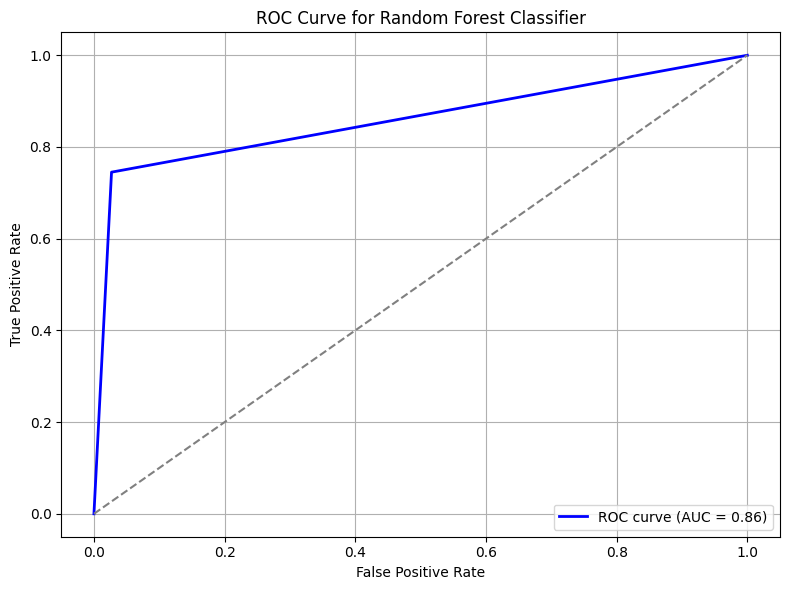

/tmp/ipython-input-116-529247673.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette='viridis')


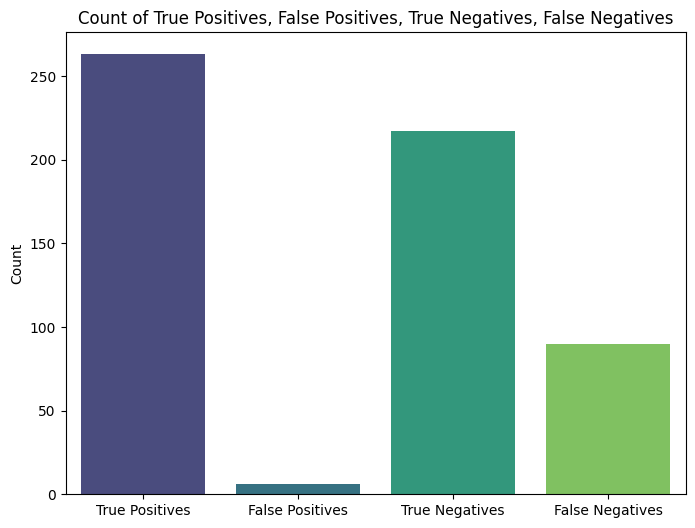

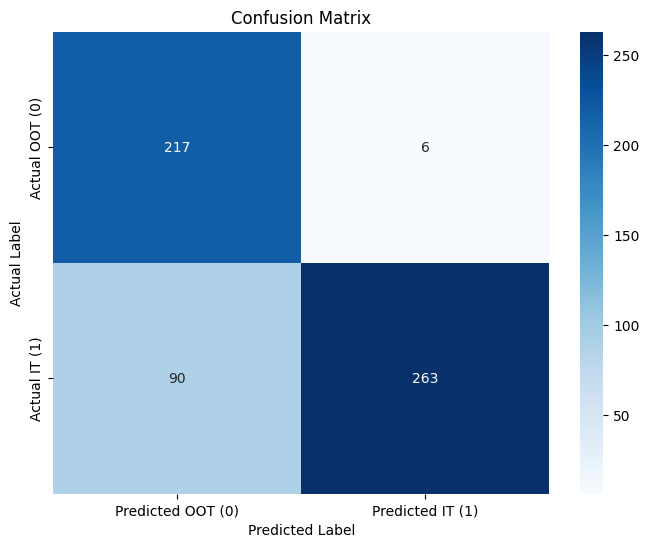

In [116]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, confusion_matrix

merge_df_inference_4o_B = pd.merge(results_df_B_4o, human_labeled_inference_results, on='text', suffixes=('_4o', '_hlabel'))
y_true = [int(label) for label in merge_df_inference_4o_B['human_label']]
y_pred = [int(label) if str(label).strip() in ['0', '1'] else 0 for label in merge_df_inference_4o_B['prediction']]

# y_true = np.array(merge_df_inference_4o_B['human_label']).astype(str)
# y_pred = np.array(merge_df_inference_4o_B['prediction']).astype(str)
evaluate_models(y_true, y_pred)

 # Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
# Create a dictionary or list for plotting
counts = {'True Positives': tp,
        'False Positives': fp,
        'True Negatives': tn,
        'False Negatives': fn}

# Plotting the counts
plt.figure(figsize=(8, 6))
sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette='viridis')
plt.ylabel('Count')
plt.title('Count of True Positives, False Positives, True Negatives, False Negatives')
plt.show()

# Display the confusion matrix as a heatmap as well
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
          xticklabels=['Predicted OOT (0)', 'Predicted IT (1)'],
          yticklabels=['Actual OOT (0)', 'Actual IT (1)'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [117]:
# save to file merge_df_inference_4o_B
results_df_B_35_turbo.to_csv('drive/MyDrive/ColabNotebooks/GirlEffect/sheng_project/data/inference_data/merge_df_inference_4o_B.csv', index=False)

***Accuracy: 0.7430555555555556 and F1: 0.7436597485601912
***Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.68      0.67       223
           1       0.80      0.78      0.79       353

    accuracy                           0.74       576
   macro avg       0.73      0.73      0.73       576
weighted avg       0.74      0.74      0.74       576

------------------------------------------------------------


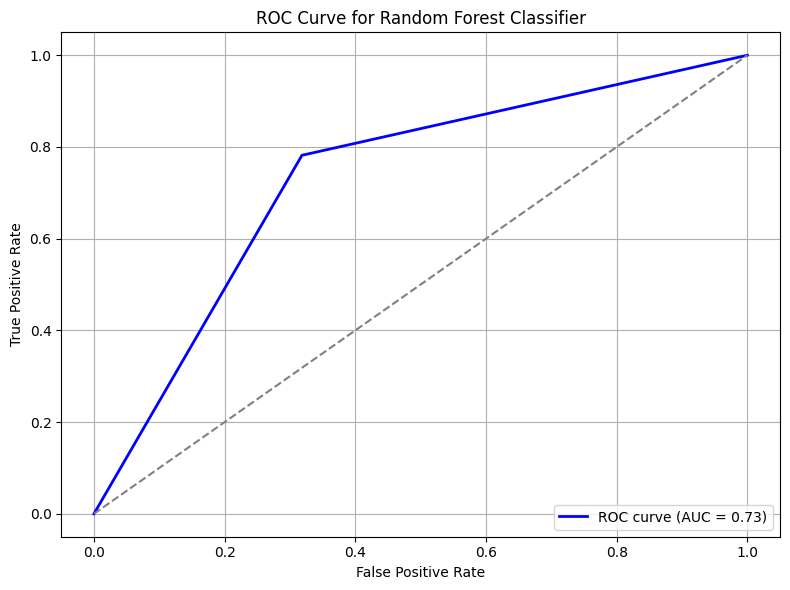

/tmp/ipython-input-119-4169495619.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette='viridis')


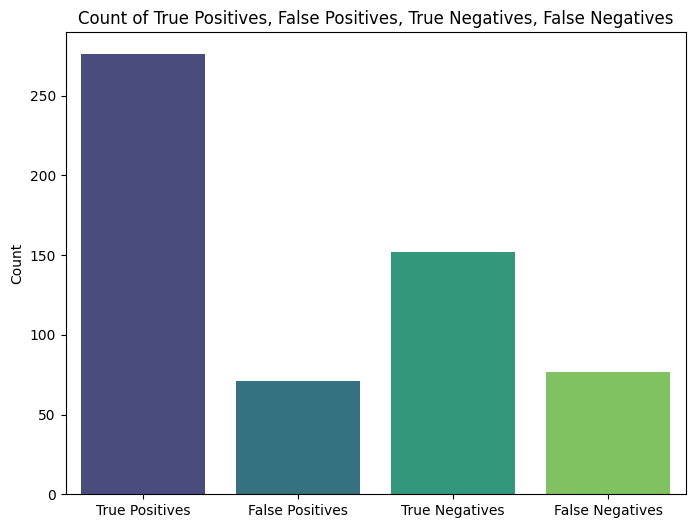

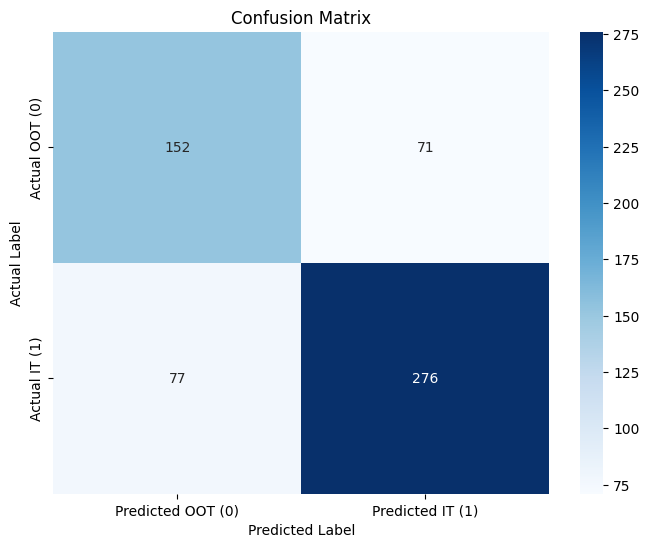

In [119]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, confusion_matrix

merge_df_inference_35_B_turbo = pd.merge(results_df_B_35_turbo, human_labeled_inference_results, on='text', suffixes=('_35', '_hlabel'))
y_true = [int(label) for label in merge_df_inference_35_B_turbo['human_label']]
y_pred = [int(label) if str(label).strip() in ['0', '1'] else 0 for label in merge_df_inference_35_B_turbo['prediction']]

# y_true = np.array(merge_df_inference_4o_B['human_label']).astype(str)
# y_pred = np.array(merge_df_inference_4o_B['prediction']).astype(str)
evaluate_models(y_true, y_pred)

 # Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
# Create a dictionary or list for plotting
counts = {'True Positives': tp,
        'False Positives': fp,
        'True Negatives': tn,
        'False Negatives': fn}

# Plotting the counts
plt.figure(figsize=(8, 6))
sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette='viridis')
plt.ylabel('Count')
plt.title('Count of True Positives, False Positives, True Negatives, False Negatives')
plt.show()

# Display the confusion matrix as a heatmap as well
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
          xticklabels=['Predicted OOT (0)', 'Predicted IT (1)'],
          yticklabels=['Actual OOT (0)', 'Actual IT (1)'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [121]:
merge_df_inference_35_B_turbo.to_csv('drive/MyDrive/ColabNotebooks/GirlEffect/sheng_project/data/inference_data/merge_df_inference_35_B_turbo.csv', index=False)

In [125]:
#Check in no response from OpenAI
len(merge_df_inference_35_B_turbo[merge_df_inference_35_B_turbo['prediction'] == "Err"])
len(merge_df_inference_4o_B[merge_df_inference_4o_B['prediction'] == "Err"])

2

# [Experiment 1 link document is here](https://https://colab.research.google.com/drive/1ThcmVsQPMzuK2fCrBX9TP_wxdndpkk_2?usp=sharing)
